# Test with open source dataset of static hand gestures
Link to download preprocessed hand gestures:

https://www.kaggle.com/ardamavi/sign-language-digits-dataset/download




In [75]:
import numpy as np
import matplotlib.pyplot as plt

from  tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense , Flatten, Dropout
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

import seaborn as sns
from sklearn.metrics import classification_report
import pandas as pd
import scikitplot as skplt

import warnings
warnings.filterwarnings("ignore")

In [6]:
x = np.load('./dataset/sign-language/X.npy')
y = np.load('./dataset/sign-language/Y.npy')

print(f'X shape: {x.shape}')
print(f'Y shape: {y.shape}')

X shape: (2062, 64, 64)
Y shape: (2062, 10)


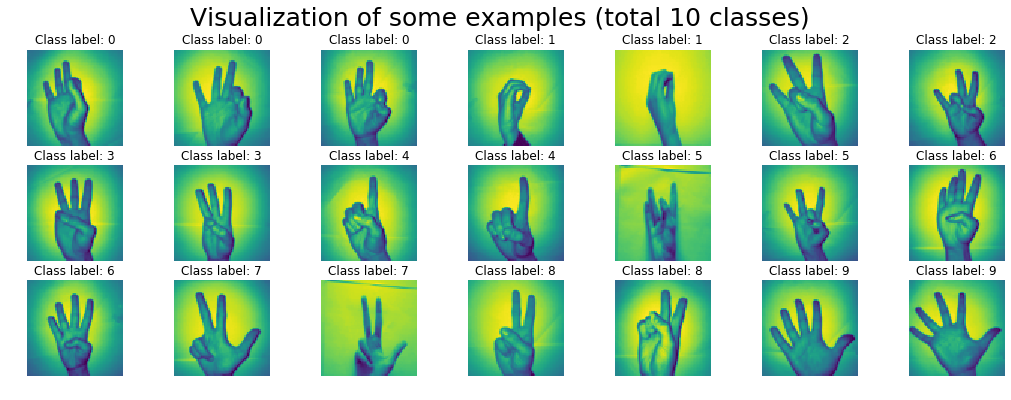

In [16]:
plt.figure(figsize=(18, 6))
figIdx = 1
for i in range(len(x)):
    if i%100==0 and figIdx <= 3*7:
        plt.subplot(3,7,figIdx)
        plt.title(f'Class label: {y[i].argmax()}')
        plt.imshow(x[i])
        plt.axis('off')
        figIdx+=1
plt.suptitle(f'Visualization of some examples (total {y.shape[1]} classes)', fontsize=25)
plt.show()

In [18]:
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, random_state = 42)
xTrain = xTrain.reshape(-1, 64, 64, 1)
xTest = xTest.reshape(-1, 64, 64, 1)

In [20]:
def cnn(numClasses):
    cnn = Sequential()
    cnn.add(Conv2D(filters=16,kernel_size=(5,5),activation="relu",padding="same",input_shape=(64,64,1)))
    cnn.add(Conv2D(filters=32,kernel_size=(5,5),activation="relu",padding="same"))
    cnn.add(MaxPooling2D(pool_size=(2,2),padding="same"))
    
    cnn.add(Conv2D(filters=32,kernel_size=(4,4),activation="relu",padding="same"))
    cnn.add(Conv2D(filters=32,kernel_size=(4,4),activation="relu",padding="same"))
    cnn.add(MaxPooling2D(pool_size=(2,2),padding="same"))
    
    cnn.add(Dropout(0.2))
    
    cnn.add(Conv2D(filters=32,kernel_size=(3,3),activation="relu",padding="same"))
    cnn.add(Conv2D(filters=64,kernel_size=(3,3),activation="relu",padding="same"))
    
    cnn.add(Dropout(0.2))
    
    cnn.add(Conv2D(filters=32,kernel_size=(2,2),activation="relu",padding="same"))
    cnn.add(MaxPooling2D(pool_size=(2,2),padding="same"))
    
    cnn.add(Dropout(0.2))
    
    cnn.add(Flatten())
    
    cnn.add(Dense(128, activation='relu'))
    cnn.add(Dense(64, activation='relu'))
    cnn.add(Dense(numClasses, activation='softmax'))
    
    cnn.summary()
    
    cnn.compile(optimizer=Adam(lr=0.0002), 
                loss = keras.losses.categorical_crossentropy, 
                metrics = ['accuracy'])
    
    return cnn

In [21]:
model = cnn(10)






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 16)        416       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        16416     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 32)        16416     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
______________________

In [23]:
history = model.fit(xTrain, yTrain, epochs=50, validation_data=(xTest, yTest))



Train on 1649 samples, validate on 413 samples
Epoch 1/50
1649/1649 [==============================] - 17s 11ms/step - loss: 2.3044 - acc: 0.0964 - val_loss: 2.3029 - val_acc: 0.0920
Epoch 2/50
1649/1649 [==============================] - 15s 9ms/step - loss: 2.3030 - acc: 0.0995 - val_loss: 2.3033 - val_acc: 0.0799
Epoch 3/50
1649/1649 [==============================] - 16s 10ms/step - loss: 2.3024 - acc: 0.1140 - val_loss: 2.3031 - val_acc: 0.0969
Epoch 4/50
1649/1649 [==============================] - 16s 10ms/step - loss: 2.3015 - acc: 0.1061 - val_loss: 2.3023 - val_acc: 0.1162
Epoch 5/50
1649/1649 [==============================] - 17s 10ms/step - loss: 2.2718 - acc: 0.1455 - val_loss: 2.0745 - val_acc: 0.2494
Epoch 6/50
1649/1649 [==============================] - 17s 10ms/step - loss: 1.4617 - acc: 0.4991 - val_loss: 1.0222 - val_acc: 0.6683
Epoch 7/50
1649/1649 [==============================] - 18s 11ms/step - loss: 0.8515 - acc: 0.7241 - val_loss: 0.6723 - val_acc: 0.7990
E

In [157]:
model.save_weights('./weights/cnn_1.h5')

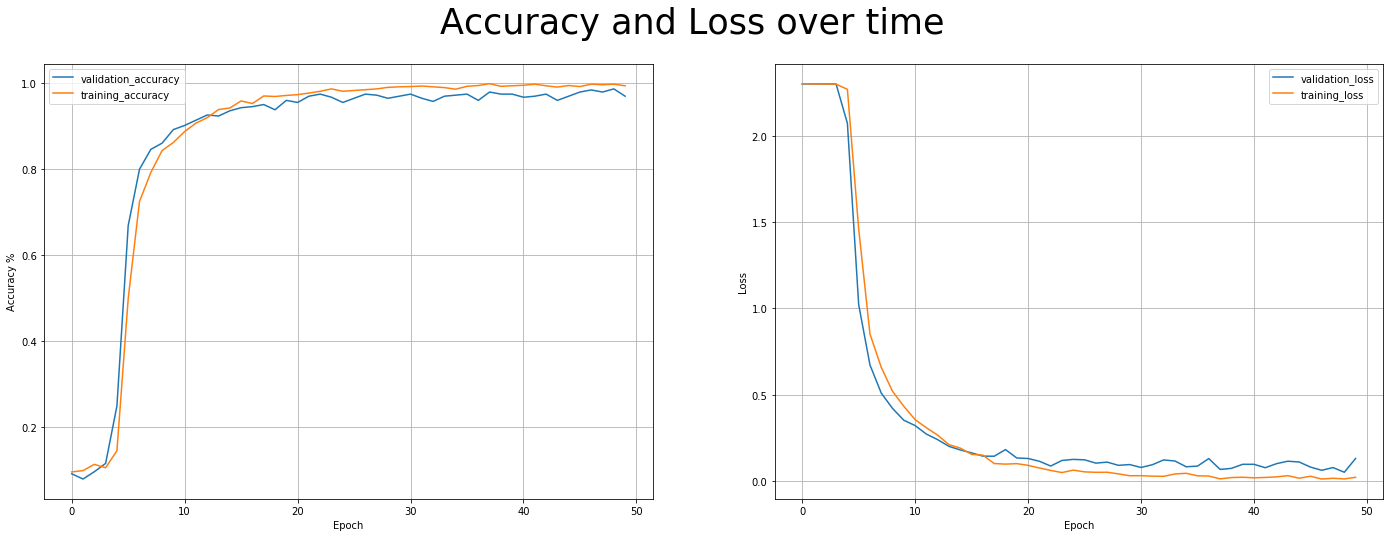

In [25]:
plt.figure(figsize=(24,8))

plt.subplot(1,2,1)
plt.plot(history.history["val_acc"],label="validation_accuracy")
plt.plot(history.history["acc"],label="training_accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy %')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history["val_loss"],label="validation_loss")
plt.plot(history.history["loss"],label="training_loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.suptitle("Accuracy and Loss over time",fontsize=35)

plt.show()


In [26]:
pred = model.predict(xTest)
predLabels = np.argmax(pred, axis = 1)
yLabels = np.argmax(yTest, axis=1)

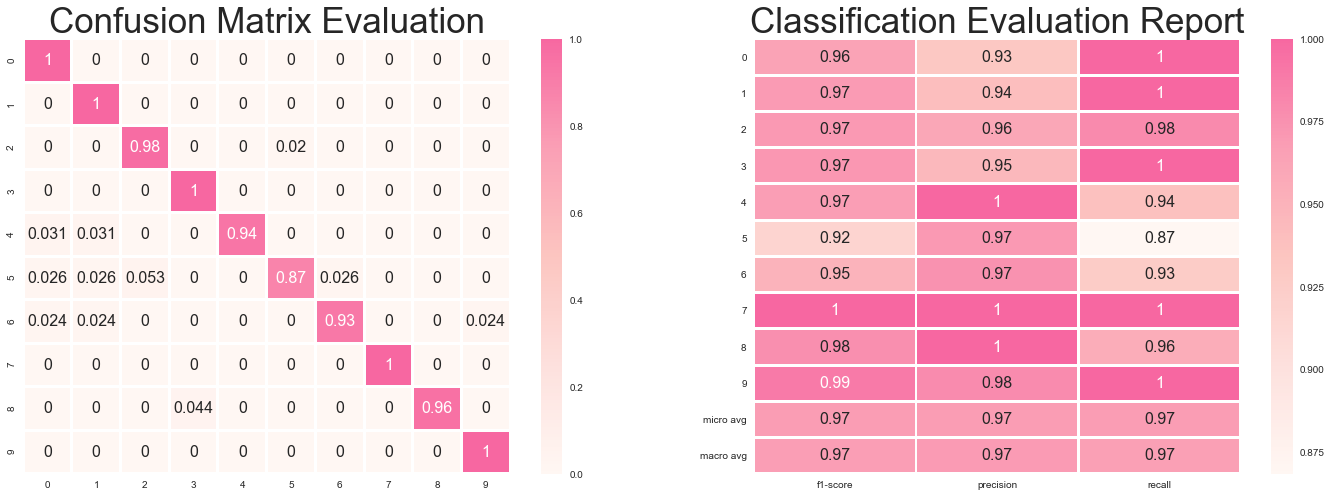

<Figure size 576x396 with 0 Axes>

In [181]:
cm = confusion_matrix(trueLabels, predLabels)
cmNorm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cmNorm, index = [i for i in "0123456789"],
                  columns = [i for i in "0123456789"])

target_names = list("0123456789")
labels = np.arange(10)
clf_report = classification_report(trueLabels,
                                   predLabels,
                                   labels=labels,
                                   target_names=target_names,
                                   output_dict=True)


plt.figure(figsize=(24,8))
plt.subplot(1,2,1)
sns.heatmap(df_cm, annot=True, cmap="RdPu", 
                center=True, linewidths=2,annot_kws={'size':16})
plt.title('Confusion Matrix Evaluation', fontsize=35)


plt.subplot(1,2,2)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1,:-1].T, 
            annot=True,cmap="RdPu", center=True, linewidths=2,annot_kws={'size':16})
plt.title('Classification Evaluation Report', fontsize = 35)

plt.show()
plt.savefig('./Evaluation/cnn.png')